# DDIM Inversion

## Setup

In [1]:
!pip install -q transformers diffusers accelerate matplotlib tqdm


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def load_image(url, size=None):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize(size) if size is not None else img
    
    return img

## Loading an existing pipeline

In [5]:
# load pretrained checkpoint
pipe = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5').to(device)

# set up a DDIM scheduler
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

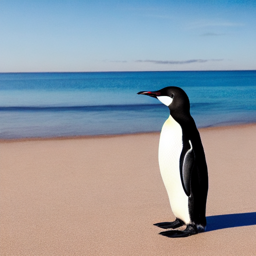

In [6]:
prompt = 'Beautiful DSLR Photograph of a pinguin on the beach, golden hour'
negative_prompt = 'blurry, ugly, stock photo'
im = pipe(prompt, negative_prompt=negative_prompt).images[0]
im.resize((256, 256))

## DDIM Sampling

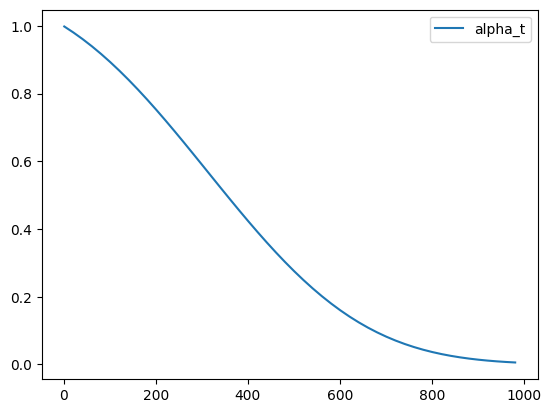

In [7]:
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps, alphas, label='alpha_t')
plt.legend()
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

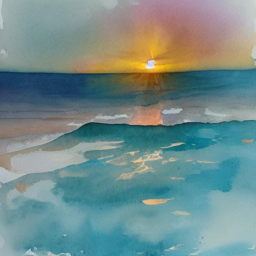

In [8]:
prompt = 'watercolor painting of a beach sunset'
num_images_per_prompt = 1
do_classifier_free_guidance = True
negative_prompt = ''
num_inference_steps = 30
start_latents = None
start_step = 0
guidance_scale = 3.5

# text encoder
text_embeddings = pipe._encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    do_classifier_free_guidance,
    negative_prompt
)

# set up inference steps
pipe.scheduler.set_timesteps(num_inference_steps, device)

# create a random starting point if we don't have one already
if start_latents is None:
    start_latents = torch.randn(1, 4, 64, 64, device=device)
    start_latents *= pipe.scheduler.init_noise_sigma
    
latents = start_latents.clone()

for i in tqdm(range(start_step, num_inference_steps)):
    
    t = pipe.scheduler.timesteps[i]
    
    # expande latents when enabling classifier free guidance (CFG)
    latent_input_model = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    
    # apply schduler's scaling on the input latents
    latent_input_model = pipe.scheduler.scale_model_input(latent_input_model, t)
    
    # predict noise residual
    with torch.inference_mode():
        noise_pred = pipe.unet(latent_input_model, t, encoder_hidden_states=text_embeddings).sample
        
    # apply classifier free guidance (CFG)
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
     
    # normally we would use scheduler.step to estiamte the latent at t-1
    # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    
    # instead, in this example we perform that step manually
    prev_t = max(1, t.item() - (1000//num_inference_steps))
    alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
    alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
    predicted_x0 = (latents - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
    direction_pointing_to_xt = (1 - alpha_t_prev).sqrt() * noise_pred
    latents = alpha_t_prev.sqrt() * predicted_x0 + direction_pointing_to_xt

# post-processing
with torch.inference_mode():
    images = pipe.decode_latents(latents)
images = pipe.numpy_to_pil(images)

images[0].resize((256, 256))

In [9]:
# prompt = 'watercolor painting of a beach sunset'
# num_images_per_prompt = 1
# do_classifier_free_guidance = True
# negative_prompt = ''
# num_inference_steps = 30
# start_latents = None
# start_step = 0
# guidance_scale = 3.5

generator = torch.Generator(device=device).manual_seed(42)

def sample(
    prompt: str,
    num_images_per_prompt: int = 1,
    do_classifier_free_guidance: bool = True,
    negative_prompt: str = '',
    num_inference_steps: int = 30,
    start_latents: torch.Tensor = None,
    start_step: int = 0,
    guidance_scale: int = 3.5,
    device: torch.device = device,
    deterministic: bool = False,
    seed: int = 42
):
    
    generator = torch.Generator(device=device).manual_seed(seed) if deterministic else None
    
    # text encoder
    text_embeddings = pipe._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt
    )

    # set up inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device)

    # create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device, generator=generator)
        start_latents *= pipe.scheduler.init_noise_sigma
    
    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):

        t = pipe.scheduler.timesteps[i]

        # expande latents when enabling classifier free guidance (CFG)
        latent_input_model = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

        # apply schduler's scaling on the input latents
        latent_input_model = pipe.scheduler.scale_model_input(latent_input_model, t)

        # predict noise residual
        with torch.inference_mode():
            noise_pred = pipe.unet(latent_input_model, t, encoder_hidden_states=text_embeddings).sample

        # apply classifier free guidance (CFG)
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # normally we would use scheduler.step to estiamte the latent at t-1
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # instead, in this example we perform that step manually
        prev_t = max(1, t.item() - (1000//num_inference_steps))
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1 - alpha_t_prev).sqrt() * noise_pred
        latents = alpha_t_prev.sqrt() * predicted_x0 + direction_pointing_to_xt

    # post-processing
    with torch.inference_mode():
        images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

  0%|          | 0/50 [00:00<?, ?it/s]

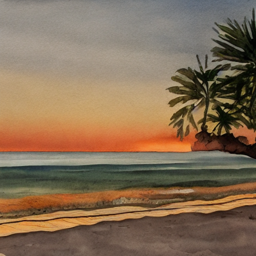

In [10]:
sample(
    prompt='Watercolor painting of a beach sunset',
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    deterministic=True,
    seed=42
)[0].resize((256, 256))

## Inversion

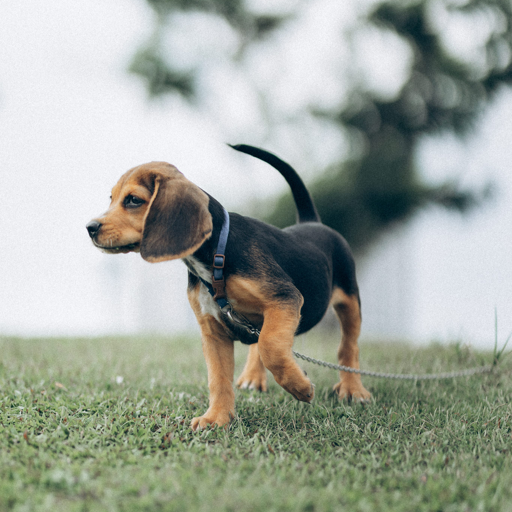

In [18]:
sample_img_url = 'https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg'
input_image = load_image(sample_img_url, size=(512, 512))
input_image

In [19]:
# define prompt to describe input image
input_image_prompt = 'Photograph of a puppy on the grass'

In [20]:
# turn image into latent using a VAE

with torch.inference_mode():
    latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)

l = 0.18215 * latent.latent_dist.sample()

In [21]:
start_latents = l
prompt = input_image_prompt
guidance_scale = 3.5
num_inference_steps = 50
num_images_per_prompt = 1
do_classifier_free_guidance = True
negative_prompt = ''

# compute text embeddings
text_embeddings = pipe._encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    do_classifier_free_guidance,
    negative_prompt
)

latents = start_latents.clone()

intermediate_latents = []

pipe.scheduler.set_timesteps(num_inference_steps, device=device)

timesteps = reversed(pipe.scheduler.timesteps)

for i in tqdm(range(1, num_inference_steps), total=num_inference_steps-1):
    
    if i >= num_inference_steps-1:
        continue
        
    t = timesteps[i]
    
    # expand latents in case classifier free guidance is applied
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    
    # predict noise residual
    with torch.inference_mode():
        pred_noise = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    # if True apply classifier free guidance (CFG)
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = pred_noise.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
    
    current_t = max(0, t.item() - (1000//num_inference_steps))
    next_t = t
    alpha_t = pipe.scheduler.alphas_cumprod[current_t]
    alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]
    
    latents = (latents - (1 - alpha_t).sqrt() * noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (1 - alpha_t_next).sqrt() * noise_pred
    
    intermediate_latents.append(latents)
    
inverted_latents = torch.cat(intermediate_latents)

  0%|          | 0/49 [00:00<?, ?it/s]

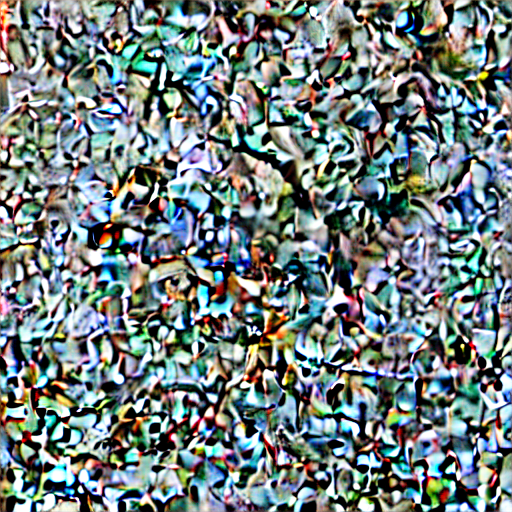

In [27]:
with torch.inference_mode():
    im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]

  0%|          | 0/50 [00:00<?, ?it/s]

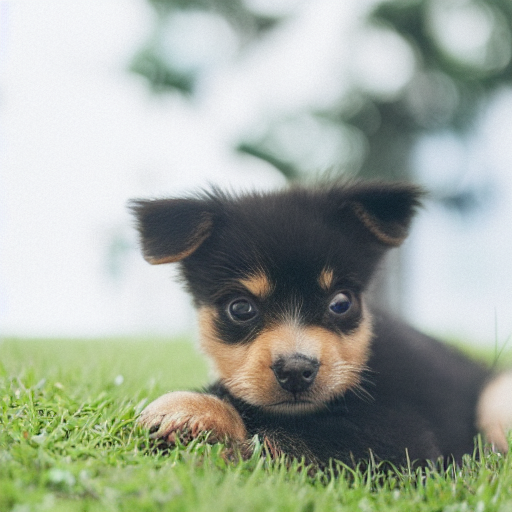

In [34]:
pipe(
    input_image_prompt,
    latents=inverted_latents[-1][None],
    num_inference_steps=50,
    guidance_scale=3.5
).images[0]

In [35]:
inverted_latents.shape

torch.Size([48, 4, 64, 64])

  0%|          | 0/30 [00:00<?, ?it/s]

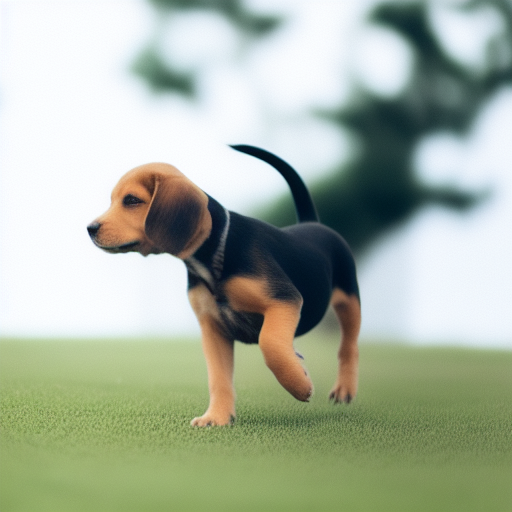

In [44]:
start_step = 20
sample(
    input_image_prompt,
    start_latents=inverted_latents[start_step-1][None],
    start_step=start_step,
    num_inference_steps=50
)[0]

  0%|          | 0/40 [00:00<?, ?it/s]

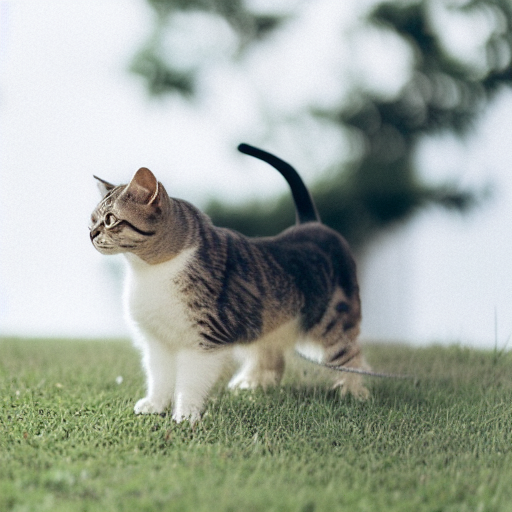

In [61]:
start_step = 10
new_prompt = input_image_prompt.replace('puppy', 'cat')

sample(
    new_prompt,
    start_latents=inverted_latents[-(start_step + 1)][None],
    # start_latents=inverted_latents[start_step-1][None],
    start_step=start_step,
    num_inference_steps=50
)[0]

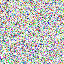

In [64]:
tfms.functional.to_pil_image(inverted_latents[-(start_step + 1)].cpu())

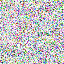

In [67]:
tfms.functional.to_pil_image(inverted_latents[0].cpu())

In [ ]:
1000 // 18